# Plot Forecasting Capabilities

In [1]:
import scipy.io as sio
import numpy as np
import torch
from torch.utils import data
import os
import matplotlib.pyplot as plt

import torch
from torch.distributions import MultivariateNormal 
from data.rot_mnist.utils import Dataset
from model.core.svgp import SVGP_Layer
from model.core.mlp import MLP
from model.core.deepgp import DeepGP
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.invodevae import INVODEVAE

/Users/ilze/PhD/virtualenv/env3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cpu'

Load data

In [3]:
fullname = os.path.join('data', "rot_mnist", "rot-mnist.mat")
dataset = sio.loadmat(fullname)

X = np.squeeze(dataset['X'])
if True:
    Y = np.squeeze(dataset['Y'])
    X = X[Y==3,:,:]

N = 360
Nvalid = 40 + N
Ntest = 40 + Nvalid
T = 16
Xtr   = torch.tensor(X[:N],dtype=torch.float32).view([N,T,1,28,28])
Xvalid = torch.tensor(X[N:Nvalid],dtype=torch.float32).view([-1,T,1,28,28])
Xtest = torch.tensor(X[Nvalid:Ntest],dtype=torch.float32).view([-1,T,1,28,28])

# Generators
params = {'batch_size': 20, 'shuffle': True, 'num_workers': 2} #25
trainset = Dataset(Xtr)
trainset = data.DataLoader(trainset, **params)
validset  = Dataset(Xvalid)
validset  = data.DataLoader(validset, **params)
testset  = Dataset(Xtest)
testset  = data.DataLoader(testset, **params)



Initialize Models

In [4]:
invode_gp = INVODEVAE(flow=Flow(diffeq=SVGP_Layer(D_in=6, D_out=6, #2q, q
                        M=100,
                        S=256,
                        dimwise=True,
                        q_diag=False,
                        device= device,
                        kernel = 'RBF'), order=1, solver='euler', use_adjoint=False),
                        vae= VAE(frames = 5, n_filt=8, latent_dim=6 ,order= 1, device=device),
                        gp = DeepGP(6, 6, 100),
                        num_observations= N,
                        order = 1,
                        steps=5,
                        dt = 0.1)

invode_mlp = INVODEVAE(flow=Flow(diffeq=MLP(6, 6, L=2, H=100, act='relu'), order=1, solver='euler', use_adjoint=False),
                        vae= VAE(frames = 5, n_filt=8, latent_dim=6 ,order= 1, device=device),
                        gp = DeepGP(6, 6, 100),
                        num_observations= N,
                        order = 1,
                        steps=5,
                        dt = 0.1)

Load Models

In [12]:
invode_gp.to(device)
fname = 'results/rot_mnist/12_12_2022-09:44/invodevae.pth'
#fname = 'results/rot_mnist/12_12_2022-14:17/invodevae.pth'
invode_gp.load_state_dict(torch.load(fname,map_location=torch.device(device)))
invode_gp.eval()

invode_mlp.to(device)
fname = 'results/rot_mnist/23_11_2022-14:38/invodevae.pth'
invode_mlp.load_state_dict(torch.load(fname,map_location=torch.device(device)))
invode_mlp.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=6, out_features=100, bias=True)
          (1): Linear(in_features=100, out_features=100, bias=True)
          (2): Linear(in_features=100, out_features=6, bias=True)
        )
        (acts): ModuleList(
          (0): ReLU()
          (1): ReLU()
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): Encoder(
      (cnn): Sequential(
        (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (7): ReLU()
        (8): Flatten

Sample Images from test data

In [27]:
images_n = 20
test_batch = next(iter(testset))[:images_n,:].to(device) #sample 20 images'

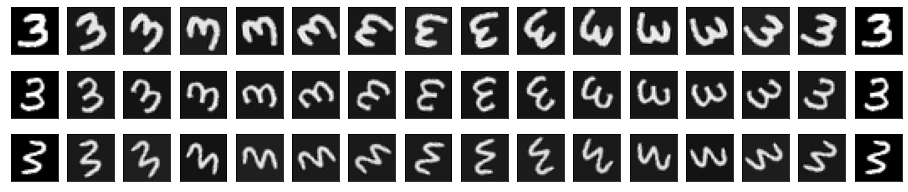

In [28]:
plt.figure(1,(20,8))
for j in range(3):
    for i in range(16):
        plt.subplot(7,20,j*20+i+1)
        plt.imshow(np.reshape(test_batch[j,i,:].cpu(),[28,28]), cmap='gray');
        plt.xticks([]); plt.yticks([])
plt.show()

In [29]:
from model.misc.plot_utils import plot_latent_traj
def plot_rot_mnist(X, Xrec, show=False, fname='rot_mnist.png', N=None, scale=2):
    if N is None:
        N = min(X.shape[0],10)
    Xnp = X.detach().cpu().numpy()
    Xrecnp = Xrec.detach().cpu().numpy()
    T = X.shape[1]
    if scale==1:
        plt.figure(2,(T,3*N))
    elif scale>=2:
        plt.figure(2,(T,N))
    for i in range(N):
        for t in range(T):
            plt.subplot(2*N,scale*T,i*T*scale*2+t+1)
            plt.imshow(np.reshape(Xnp[i,t],[28,28]), cmap='gray')
            plt.xticks([]); plt.yticks([])
        for t in range(scale*T):
            plt.subplot(2*N,T*scale,i*T*scale*2+t+T*scale+1)
            plt.imshow(np.reshape(Xrecnp[i,t],[28,28]), cmap='gray')
            plt.xticks([]); plt.yticks([])
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

## MLP-ODE

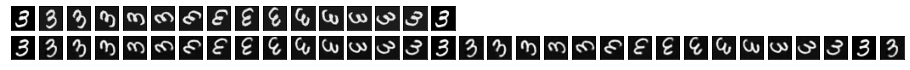

In [30]:
rollout=2
with torch.no_grad():    
    Xrec_mu, ztl, _, _  = invode_mlp(test_latent,  T_custom=rollout*T)
    plot_rot_mnist(test_latent, Xrec_mu.squeeze(0), show=True, fname='rot_mnist.png', N=1, scale=rollout)

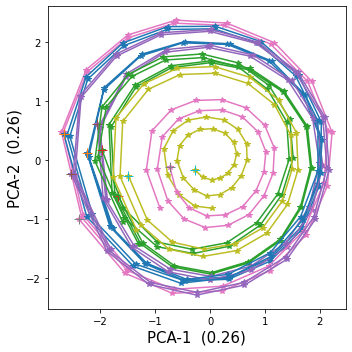

In [31]:
plot_latent_traj(ztl, show=True)


## GP-ODE

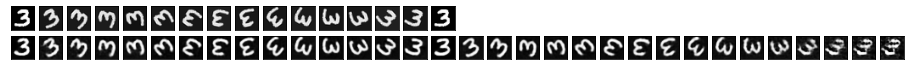

In [32]:
rollout=2
with torch.no_grad():    
    Xrec_mu, ztl, _, _  = invode_gp(test_batch,  T_custom=rollout*T)
    plot_rot_mnist(test_batch, Xrec_mu.squeeze(0), show=True, fname='rot_mnist.png', N=1, scale=rollout)

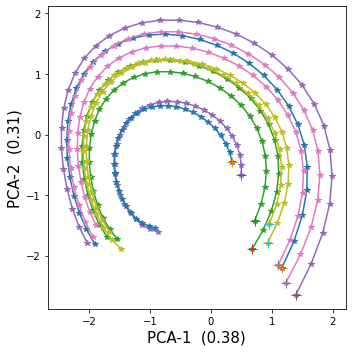

In [33]:
plot_latent_traj(ztl, show=True)